In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

matplotlib.rcParams['figure.dpi'] = 300

from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import plot_model

In [2]:
df = pd.read_csv('/content/NIFTY 100-09-11-2015-to-14-08-2024.csv', index_col='Date', parse_dates=True, date_format='%d-%b-%y')
df.head()

,Open,High,Low,Close,Volume,Turnover (? Cr)
Date,,,,,,
2015-11-09,7903.80,8068.40,7890.85,8044.45,294972687.0,11924.26
2015-11-10,8009.10,8017.40,7896.70,7907.65,275281891.0,9744.58
2015-11-11,7964.95,7973.45,7952.05,7956.40,31847545.0,1381.73
2015-11-13,7895.35,7900.35,7853.55,7886.90,264081261.0,11076.44
2015-11-16,7859.60,7948.05,7835.65,7917.45,226332965.0,9338.65


In [3]:
df = df.dropna()

print(df.isnull().sum())
print(len(df))

Open               0
High               0
Low                0
Close              0
Volume             0
Turnover (? Cr)    0
dtype: int64
2169


In [4]:
print('Dataframe Shape: ', df.shape)
print('Null Value Present: ', df.isnull().values.any())

Dataframe Shape:  (2169, 6)
Null Value Present:  False


In [5]:
#Set Target Variable
output_var = pd.DataFrame(df['Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

In [6]:
scaler_X = MinMaxScaler()
feature_transform = scaler_X.fit_transform(df[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)

scaler_Y = MinMaxScaler()
output_var_scaled = scaler_Y.fit_transform(output_var)

In [7]:
n_test = 30  # number of rows for testing
X_train, X_test = feature_transform[:-n_test], feature_transform[-n_test:]
Y_train, Y_test = output_var_scaled[:-n_test].ravel(), output_var_scaled[-n_test:].ravel()

In [8]:
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


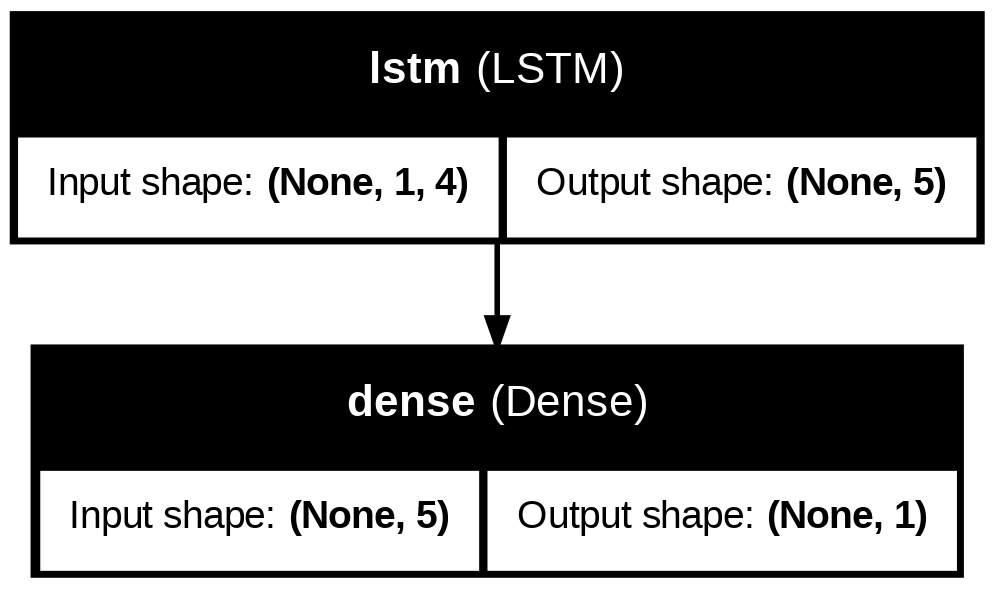

In [9]:
lstm_model = Sequential()
lstm_model.add(LSTM(5, input_shape=(1, trainX.shape[1])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='RMSProp')
plot_model(lstm_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [10]:
# Train the model
history = lstm_model.fit(X_train, Y_train, batch_size=4, epochs=200, verbose=1)

Epoch 1/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0368
Epoch 2/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5.0483e-05
Epoch 3/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2959e-05
Epoch 4/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.5867e-05
Epoch 5/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9427e-05
Epoch 6/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.5228e-05
Epoch 7/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.3413e-05
Epoch 8/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9342e-05
Epoch 9/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.2017e-05
Epoch 10/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8787e-05
Epoch 11/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4091e-05
Epoch 12/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3010e-05
Epoch 13/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2744e-05
Epoch 14/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.

In [11]:
Y2_pred = lstm_model.predict(X_train)
Y_pred = lstm_model.predict(X_test)

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [12]:
Y2_pred_original = scaler_Y.inverse_transform(Y2_pred)
Y_pred_original = scaler_Y.inverse_transform(Y_pred)

Y_train_original = scaler_Y.inverse_transform(Y_train.reshape(-1, 1))
Y_test_original = scaler_Y.inverse_transform(Y_test.reshape(-1, 1))

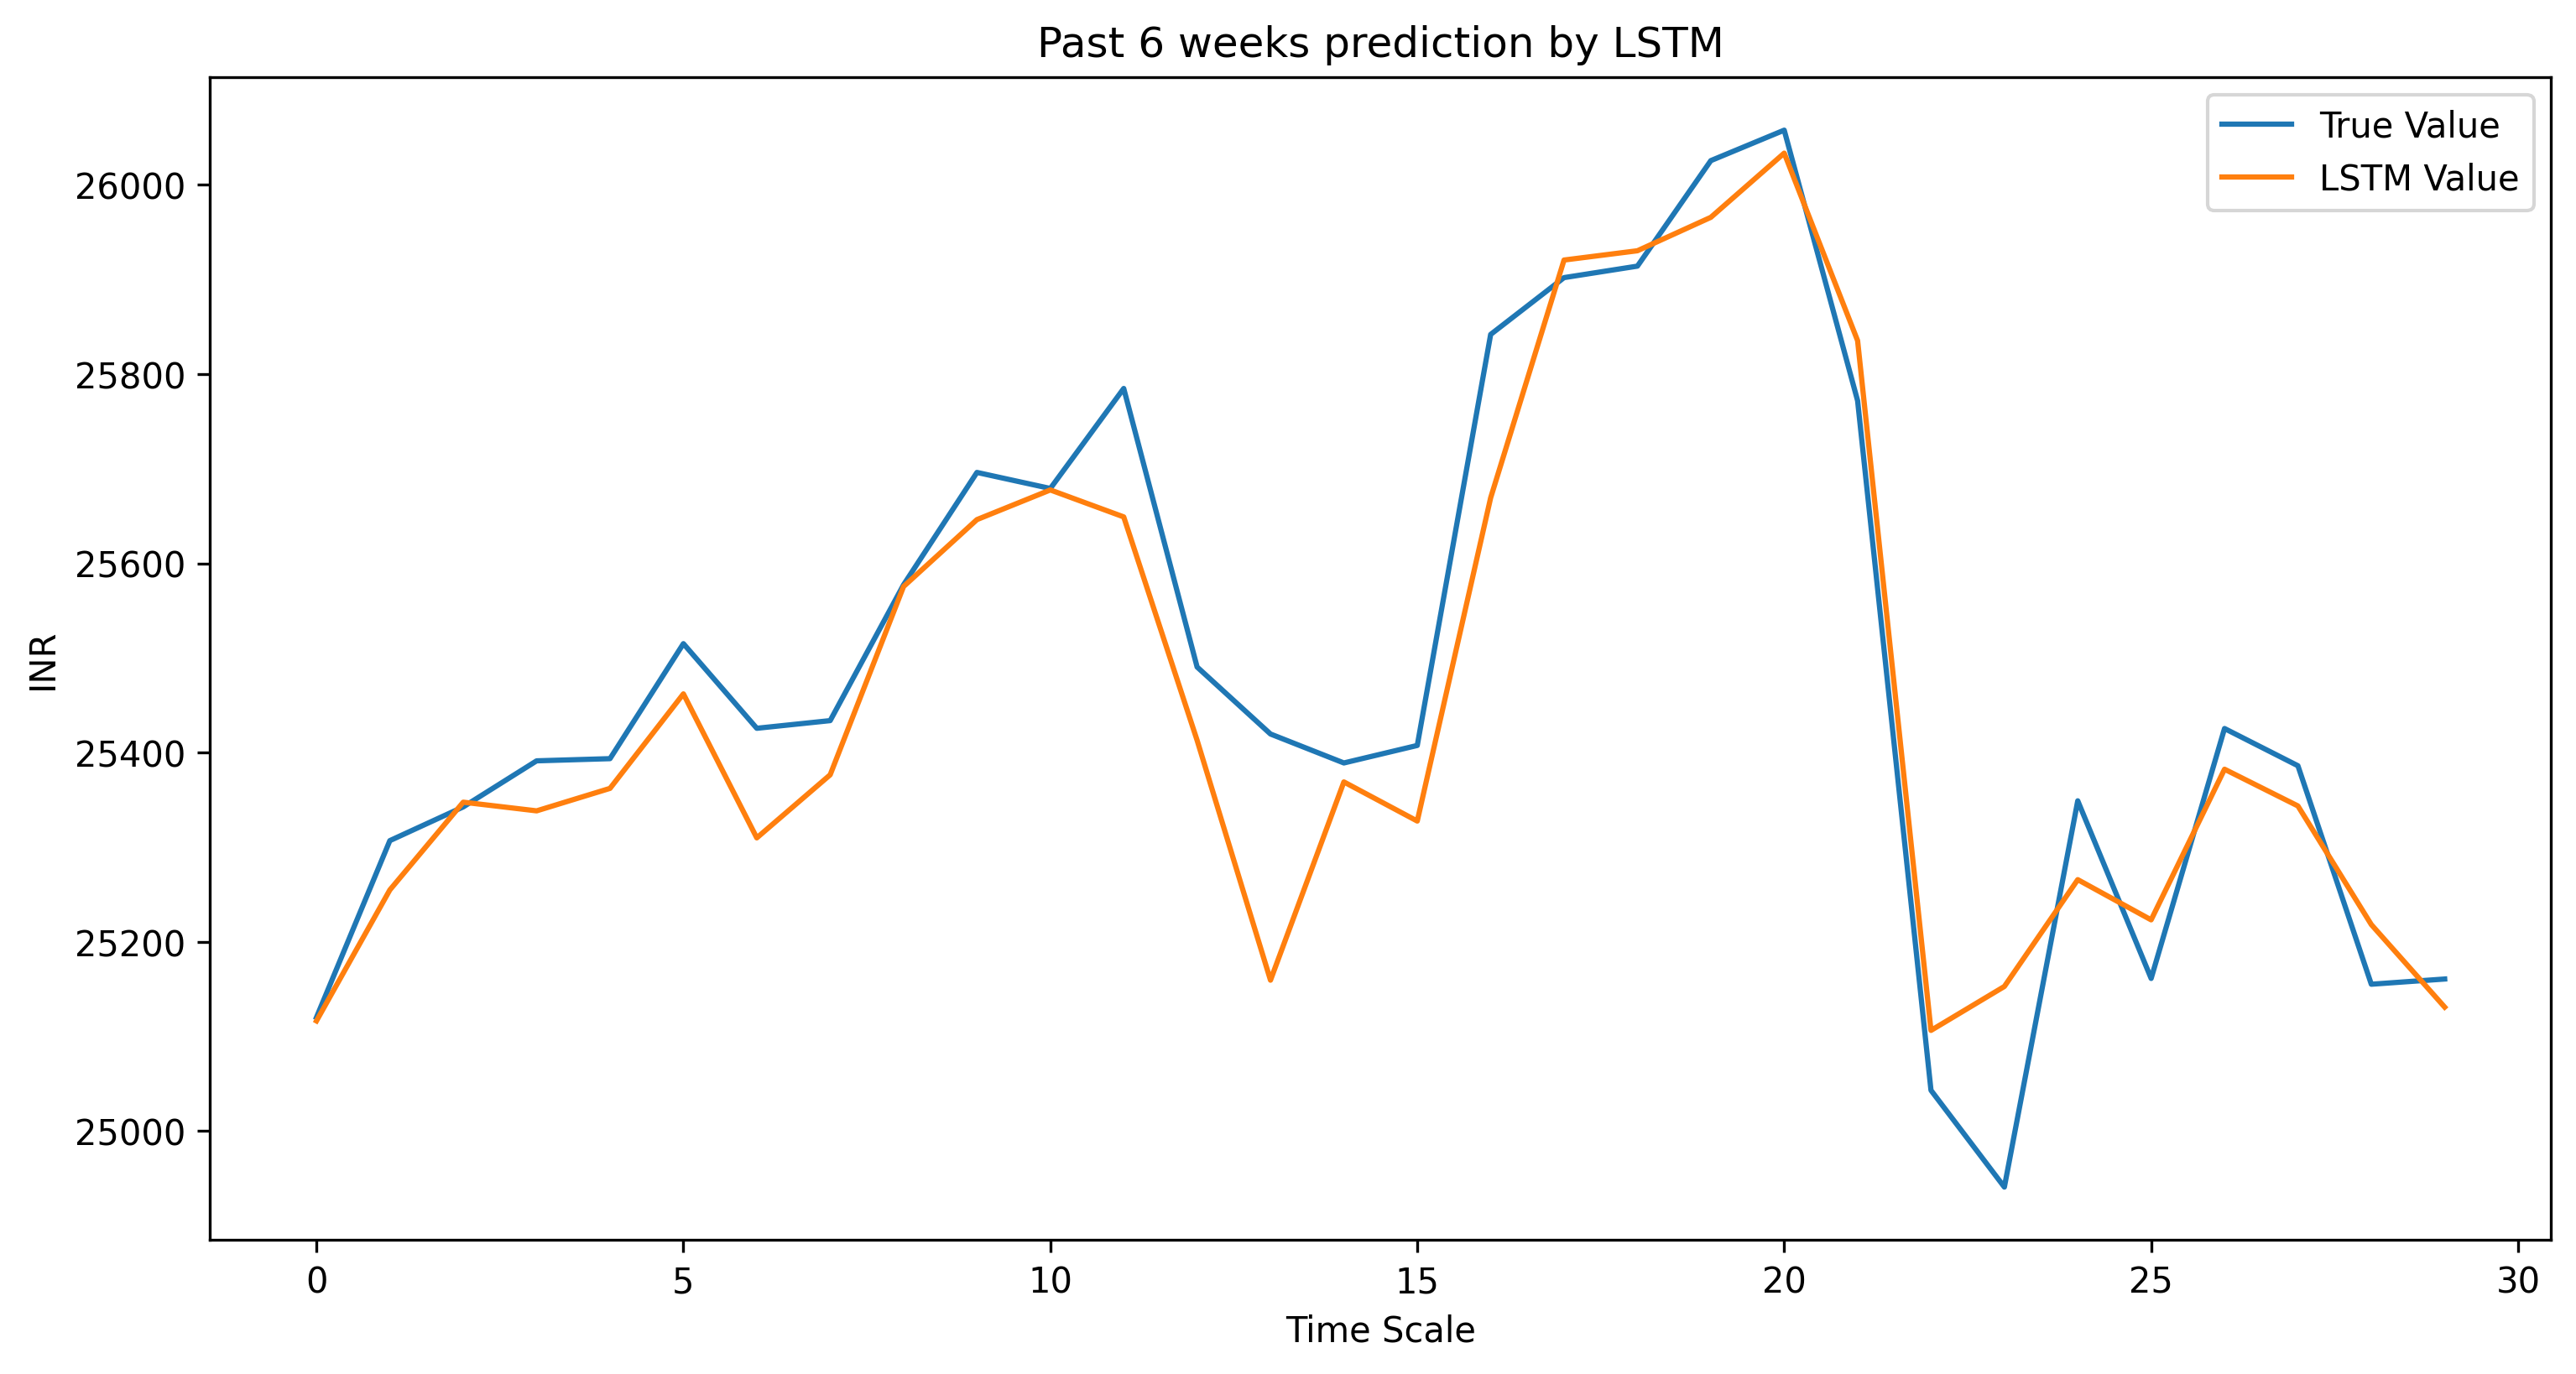

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(Y_test_original, label='True Value')
plt.plot(Y_pred_original, label='LSTM Value')
plt.title('Past 6 weeks prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('INR')
plt.legend()
plt.show()

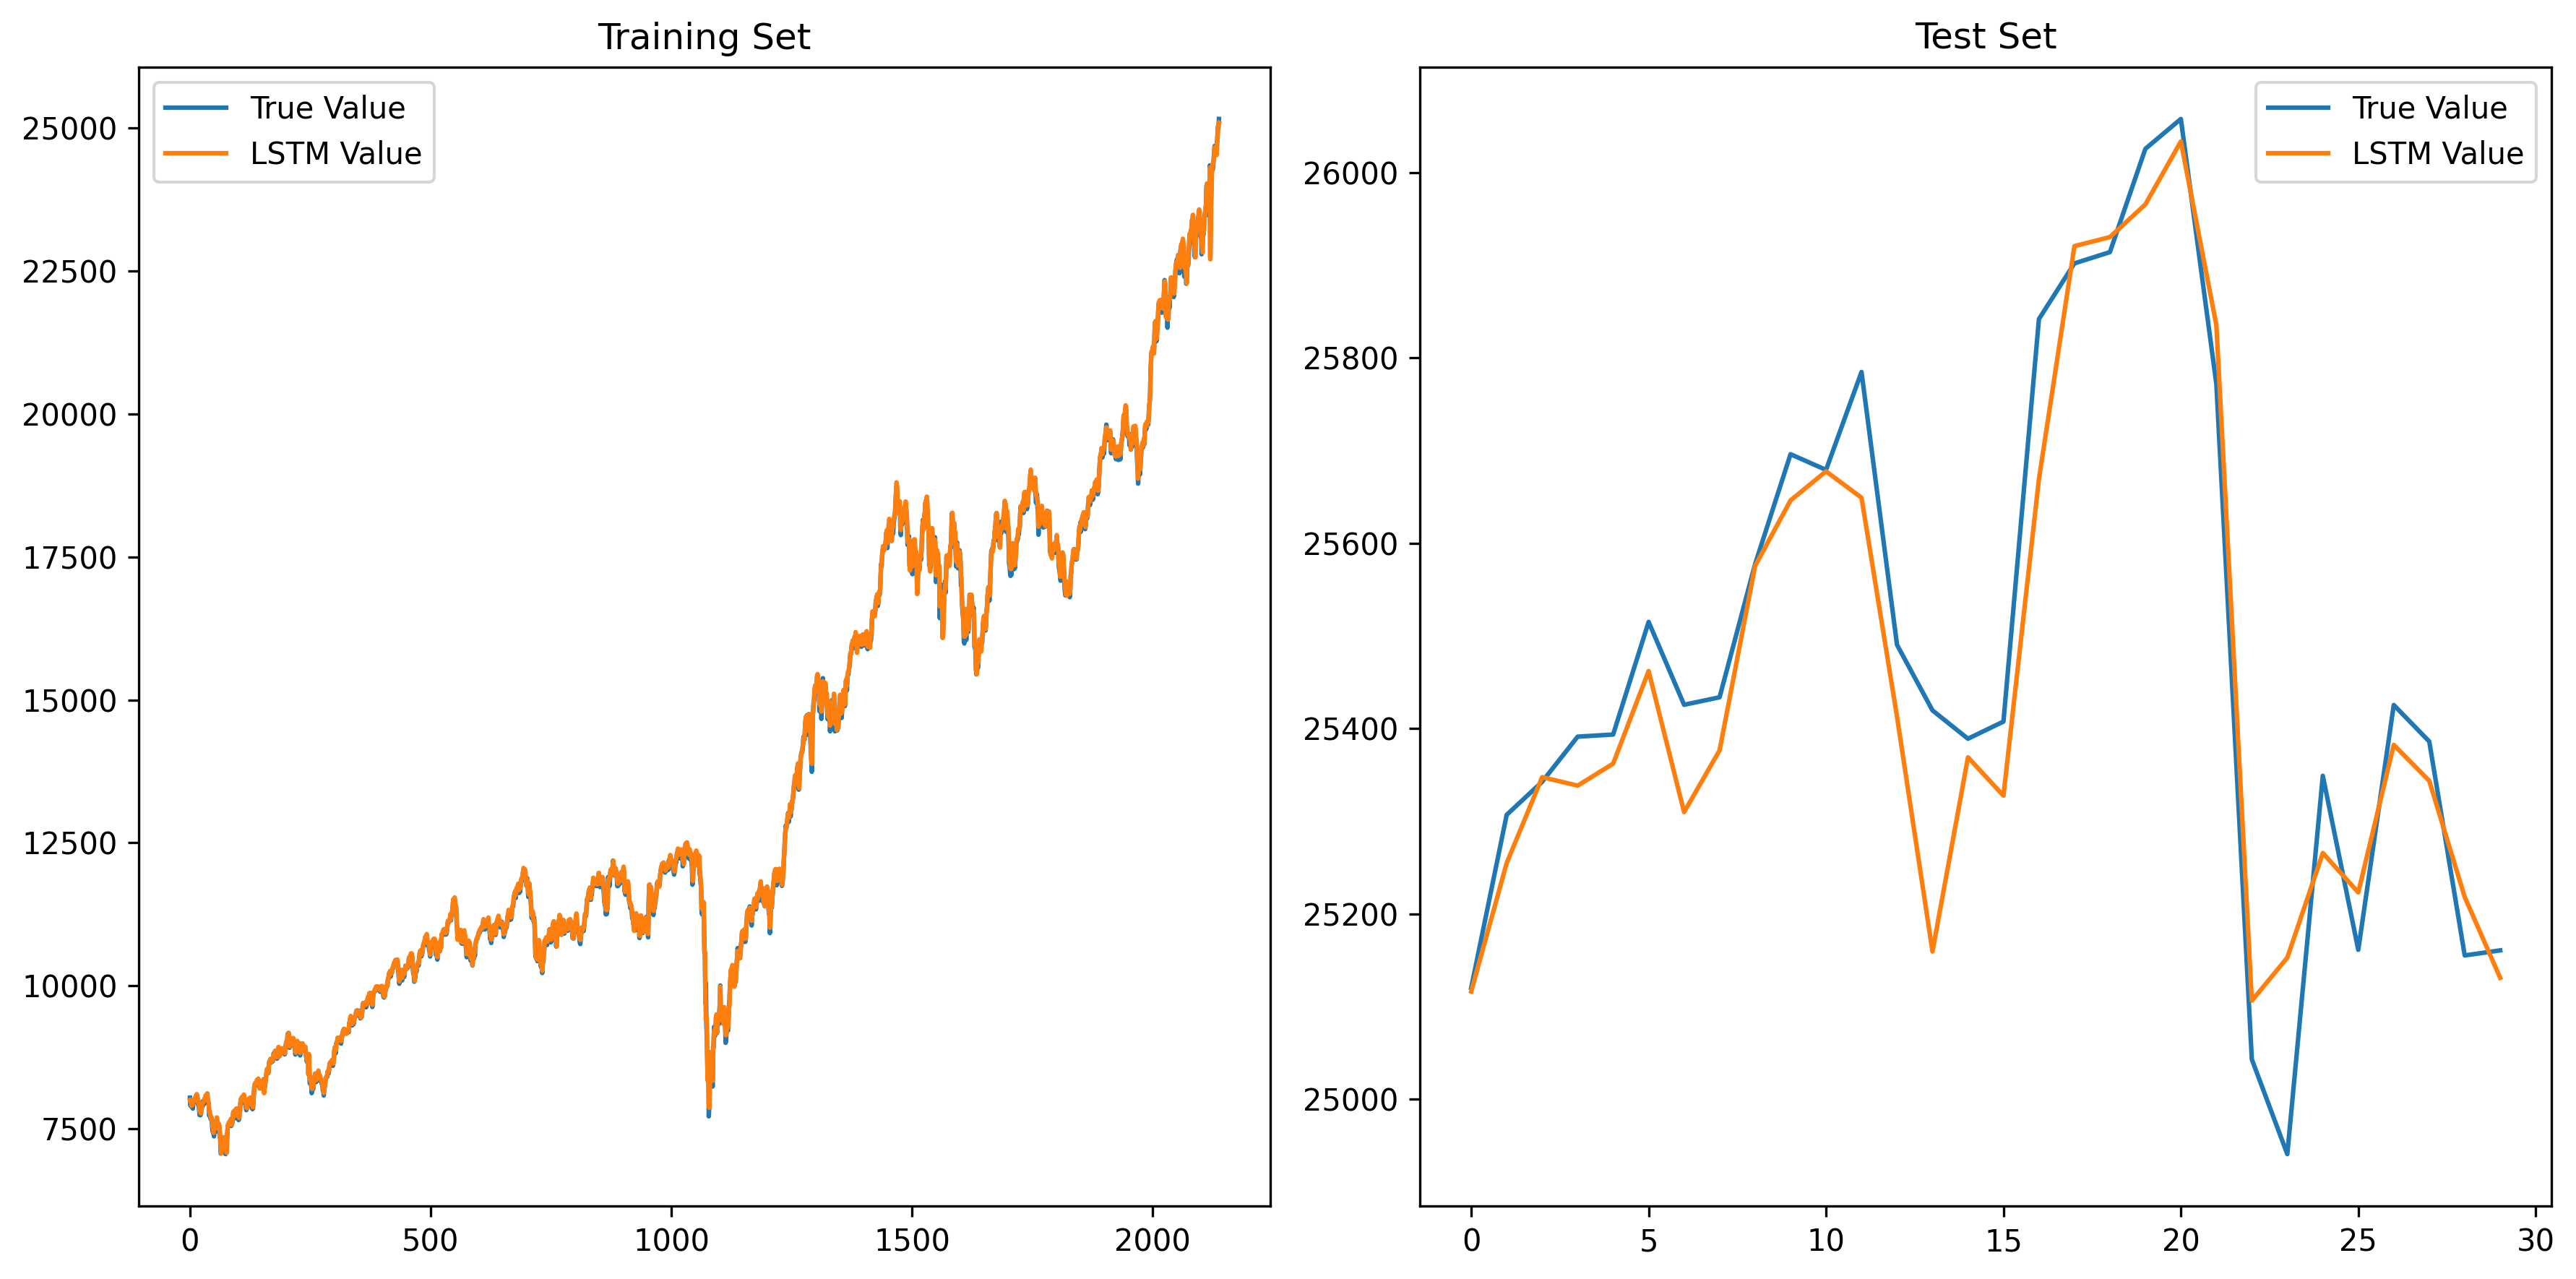

In [14]:
# Plot training and test predictions together
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Training set
ax1.plot(Y_train_original, label='True Value')
ax1.plot(Y2_pred_original, label='LSTM Value')
ax1.legend()
ax1.set_title('Training Set')

# Test set
ax2.plot(Y_test_original, label='True Value')
ax2.plot(Y_pred_original, label='LSTM Value')
ax2.legend()
ax2.set_title('Test Set')

plt.tight_layout()
plt.show()

In [15]:
lstm_model.save('lstm_weights.h5')

In [16]:
# Calculate and print Training and Testing MSE
train_rmse = mean_squared_error(Y_train_original, Y2_pred_original, squared=False)
test_rmse = mean_squared_error(Y_test_original, Y_pred_original, squared=False)
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")

Training RMSE: 57.1341
Testing RMSE: 88.3777


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
